In [1]:
# TensorFlow Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, Embedding, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Other Imports
from bs4 import BeautifulSoup
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import string
import json
import zipfile
import os

2024-02-18 04:58:38.353115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 04:58:38.353210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 04:58:38.480750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Extracting the Dataset

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json

--2024-02-18 04:58:51--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: '/tmp/sarcasm.json'

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2024-02-18 04:58:51 (158 MB/s) - '/tmp/sarcasm.json' saved [5643545/5643545]



## Transforming the Dataset

In [3]:
# A list of all the stopwords that will be filtered in the dataset
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

In [4]:
# Creating the String Translation Table
table = str.maketrans("", "", string.punctuation)

In [5]:
# Extracting the JSON file
with open("/tmp/sarcasm.json", "r") as json_file:
    extraced_file = json.load(json_file)
    
# Cleaning and Filtering the data for NLP
labels = []
sentences = []
links = []

for item in extraced_file:
    
    # Converting the Sentence to Lower Case
    sentence = item["headline"].lower()
    
    # Adding Spacing the Punctuation to aid stopword filtering
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace("/", " / ")
    sentence = sentence.replace("-", " - ")
    
    # Removing all the HTML Tags attached to the data
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    
    # Processing the Sentence for Stopwords
    filtered_sentence = ""
    words = sentence.split()
    for word in words:
        # Make Translations to the word for punctuations
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
        
    # Appending the cleaned and filtered sentence
    sentences.append(filtered_sentence)
    links.append(item["article_link"])
    labels.append(item["is_sarcastic"])
    
# Viewing the Length of the Lists after Filtering
print("Links: ", len(links))
print("Sentences: ", len(sentences))
print("Labels: ", len(labels))

/tmp/ipykernel_27/1868353646.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


Links:  26709
Sentences:  26709
Labels:  26709


In [6]:
print("Viewing some of the filtered sentences:\n")
for i in sentences[:5]:
    print(i)

Viewing some of the filtered sentences:

former versace store clerk sues secret black code minority shoppers 
roseanne revival catches thorny political mood  better worse 
mom starting fear sons web series closest thing will grandchild 
boehner just wants wife listen  not come alternative debt  reduction ideas 
j  k  rowling wishes snape happy birthday magical way 


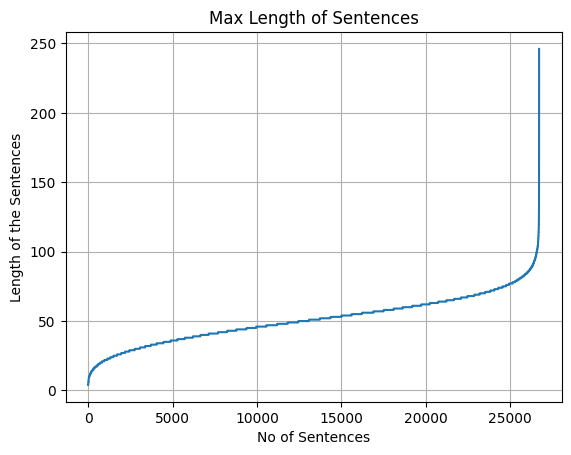

In [7]:
# Viewing the Max Length trend of the Sentences
curr_item = 1
xs, ys = [], []

for sentence in sentences:
    xs.append(curr_item)
    ys.append(len(sentence))
    curr_item += 1
    
plt.plot(xs, sorted(ys))
plt.xlabel("No of Sentences")
plt.ylabel("Length of the Sentences")
plt.title("Max Length of Sentences")
plt.grid()
plt.show()

## Applying the NLP Preparation Techniques

In [8]:
# Parameters used for Data Preparation
vocab_size = 20e3
embedding_dim = 10
maxlen = 70
train_size = 23000

In [9]:
# Tokenizing all the words in the sentences
sarcasm_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
sarcasm_tokenizer.fit_on_texts(sentences)

# Word Index of the Tokenizer
word_index = list(sarcasm_tokenizer.word_index.items())

# Converting the Texts to Sequences
sequences = sarcasm_tokenizer.texts_to_sequences(sentences)

In [10]:
print("Top 5 words based on frequency as learnt by the tokenizer:\n")
for i, j in word_index[1:6]:
    print("Word: ", i, "\nToken: ", j, end="\n\n")

Top 5 words based on frequency as learnt by the tokenizer:

Word:  new 
Token:  2

Word:  trump 
Token:  3

Word:  man 
Token:  4

Word:  not 
Token:  5

Word:  just 
Token:  6



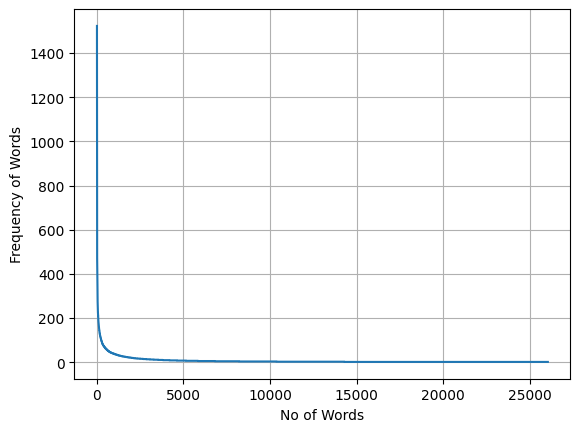

In [11]:
# Viewing the Frequency of Words
word_count = sarcasm_tokenizer.word_counts

# Storing all the words and their word counts in order of frequency
order_of_freq = OrderedDict(sorted(word_count.items(), key=lambda t: t[1], reverse=True))

curr_item = 1
xs, ys = [], []
for i in order_of_freq:
    xs.append(curr_item)
    ys.append(order_of_freq[i])
    curr_item += 1
    
plt.plot(xs, ys)
plt.xlabel("No of Words")
plt.ylabel("Frequency of Words")
plt.grid()
plt.show()

In [12]:
# Applying Padding to the Sequences
sequences = pad_sequences(sequences, padding="post", maxlen=maxlen, truncating="post")

In [13]:
print("Viewing some of the Sequences:\n")
for i in sequences[:5]:
    print(i)

Viewing some of the Sequences:

[  228 14301   588  3276  2209   287    43  2011  2498  8210     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0]
[8211 3277 2671 8212  317 2850  173  898    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
[   78   755   733  1026  2012   497  4626   138     7 10377     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0   

## Dividing the Training and Test Sets

In [14]:
train_set = np.array(sequences[:train_size])
train_labels = np.array(labels[:train_size])

test_set = np.array(sequences[train_size:])
test_labels = np.array(labels[train_size:])

## Building the Model

In [15]:
tf.keras.backend.clear_session()

In [16]:
brnn_model = Sequential([
    
    # Learning the Features of the words using embeddings
    Embedding(int(vocab_size), embedding_dim),
    
    # LSTM's dont need pooling and can feed on the raw ouput from the embedding layer
    Bidirectional(LSTM(embedding_dim)),
    
    # Hidden Layers
    Dense(24, activation="relu"),
    Dense(1, activation="sigmoid")
])

brnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          200000    
                                                                 
 bidirectional (Bidirection  (None, 20)                1680      
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                504       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 202209 (789.88 KB)
Trainable params: 202209 (789.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
brnn_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)
)

In [18]:
history = brnn_model.fit(
    train_set, train_labels, validation_data=(test_set, test_labels), epochs=40, verbose=2
)

Epoch 1/40


I0000 00:00:1708232345.897655      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


719/719 - 23s - loss: 0.6917 - accuracy: 0.5559 - val_loss: 0.6900 - val_accuracy: 0.5700 - 23s/epoch - 32ms/step
Epoch 2/40
719/719 - 6s - loss: 0.6893 - accuracy: 0.5596 - val_loss: 0.6873 - val_accuracy: 0.5700 - 6s/epoch - 9ms/step
Epoch 3/40
719/719 - 7s - loss: 0.6870 - accuracy: 0.5596 - val_loss: 0.6848 - val_accuracy: 0.5700 - 7s/epoch - 10ms/step
Epoch 4/40
719/719 - 7s - loss: 0.6851 - accuracy: 0.5596 - val_loss: 0.6828 - val_accuracy: 0.5700 - 7s/epoch - 9ms/step
Epoch 5/40
719/719 - 6s - loss: 0.6835 - accuracy: 0.5596 - val_loss: 0.6811 - val_accuracy: 0.5700 - 6s/epoch - 9ms/step
Epoch 6/40
719/719 - 6s - loss: 0.6820 - accuracy: 0.5596 - val_loss: 0.6795 - val_accuracy: 0.5700 - 6s/epoch - 9ms/step
Epoch 7/40
719/719 - 6s - loss: 0.6804 - accuracy: 0.5596 - val_loss: 0.6780 - val_accuracy: 0.5700 - 6s/epoch - 9ms/step
Epoch 8/40
719/719 - 6s - loss: 0.6787 - accuracy: 0.5596 - val_loss: 0.6763 - val_accuracy: 0.5700 - 6s/epoch - 9ms/step
Epoch 9/40
719/719 - 7s - loss:

**Performance of the Model**

In [19]:
def plot_model(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    
    plt.title(metric.capitalize() + " Evaluation")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend([metric, "val_" + metric])
    plt.show()

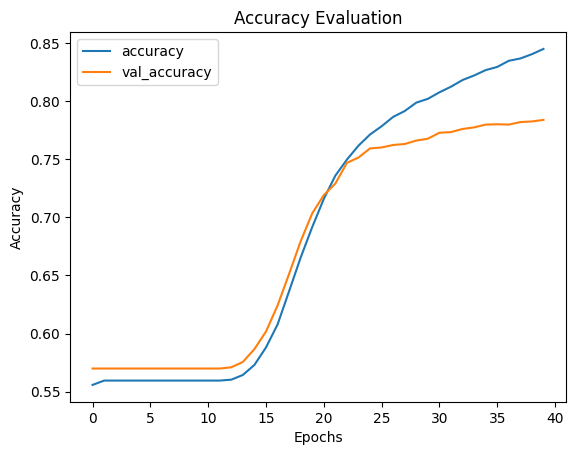

In [20]:
plot_model(history, "accuracy")

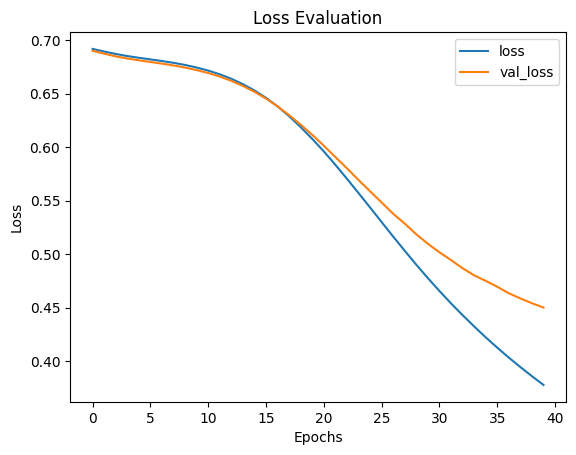

In [21]:
plot_model(history, "loss")

**Inference**
- The model seems to do quite well on both the training and test sets but seems to have bias towards the training set
- The Validation Loss seems to diverge after 15 epochs
- The Validation Accuracy seems to platue after 15 epochs

## Stacking LSTMs

In [22]:
tf.keras.backend.clear_session()

In [23]:
stacked_lstm = Sequential([
    
    # Embedding Layer
    Embedding(int(vocab_size), embedding_dim),
    
    # Stacking LSTMs
    Bidirectional(LSTM(embedding_dim, return_sequences=True)),
    Bidirectional(LSTM(embedding_dim)),
    
    # Hidden Layers
    Dense(24, activation="relu"),
    Dense(1, activation="sigmoid")
])

stacked_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          200000    
                                                                 
 bidirectional (Bidirection  (None, None, 20)          1680      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 20)                2480      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 24)                504       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 204689 (799.57 KB)
Trainable params: 20468

In [24]:
stacked_lstm.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)
)

In [25]:
history = stacked_lstm.fit(
    train_set, train_labels, validation_data=(test_set, test_labels), epochs=40, verbose=2
)

Epoch 1/40
719/719 - 24s - loss: 0.6914 - accuracy: 0.5596 - val_loss: 0.6896 - val_accuracy: 0.5700 - 24s/epoch - 33ms/step
Epoch 2/40
719/719 - 11s - loss: 0.6889 - accuracy: 0.5596 - val_loss: 0.6867 - val_accuracy: 0.5700 - 11s/epoch - 15ms/step
Epoch 3/40
719/719 - 10s - loss: 0.6868 - accuracy: 0.5596 - val_loss: 0.6844 - val_accuracy: 0.5700 - 10s/epoch - 15ms/step
Epoch 4/40
719/719 - 10s - loss: 0.6855 - accuracy: 0.5596 - val_loss: 0.6831 - val_accuracy: 0.5700 - 10s/epoch - 15ms/step
Epoch 5/40
719/719 - 10s - loss: 0.6848 - accuracy: 0.5596 - val_loss: 0.6823 - val_accuracy: 0.5700 - 10s/epoch - 14ms/step
Epoch 6/40
719/719 - 10s - loss: 0.6843 - accuracy: 0.5596 - val_loss: 0.6817 - val_accuracy: 0.5700 - 10s/epoch - 14ms/step
Epoch 7/40
719/719 - 11s - loss: 0.6838 - accuracy: 0.5596 - val_loss: 0.6811 - val_accuracy: 0.5700 - 11s/epoch - 15ms/step
Epoch 8/40
719/719 - 11s - loss: 0.6830 - accuracy: 0.5596 - val_loss: 0.6804 - val_accuracy: 0.5700 - 11s/epoch - 15ms/step


**Performance of the Model**

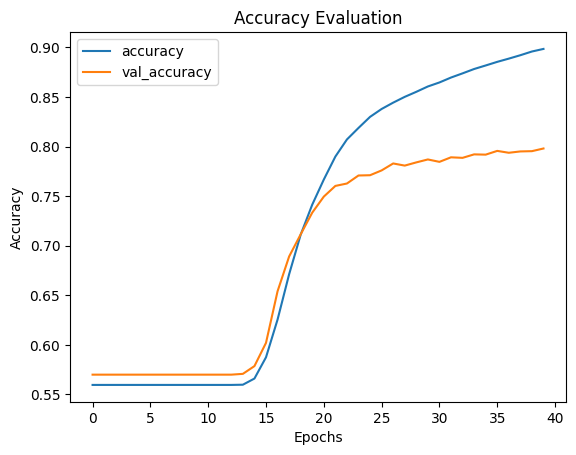

In [26]:
plot_model(history, "accuracy")

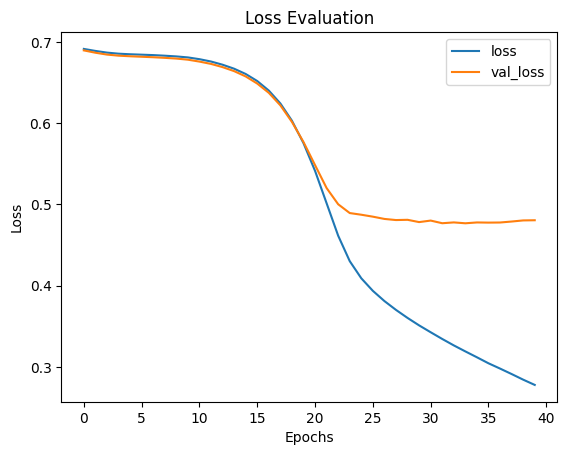

In [27]:
plot_model(history, "loss")

**Inference**
- It is clear that the model is now overfitting on to the training set after using Stacked LSTMs due to the randomness in the training data and the Hyperparameters chosen

## Optimizing the Model

- Altering the Learning Rate
- Altering the Model Architecture using Dropout

In [28]:
tf.keras.backend.clear_session()

In [29]:
stacked_lstm_mod = Sequential([
    
    # Embedding Layer
    Embedding(int(vocab_size), embedding_dim),
    
    # Stacking LSTMs
    Bidirectional(LSTM(embedding_dim, return_sequences=True, dropout=0.2)),
    Bidirectional(LSTM(embedding_dim, dropout=0.2)),
    
    # Hidden Layers
    Dense(24, activation="relu"),
    Dense(1, activation="sigmoid")
])

stacked_lstm_mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          200000    
                                                                 
 bidirectional (Bidirection  (None, None, 20)          1680      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 20)                2480      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 24)                504       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 204689 (799.57 KB)
Trainable params: 20468

In [30]:
stacked_lstm_mod.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)
)

In [31]:
history = stacked_lstm_mod.fit(
    train_set, train_labels, validation_data=(test_set, test_labels), epochs=50, verbose=2
)

Epoch 1/50
719/719 - 25s - loss: 0.6925 - accuracy: 0.5392 - val_loss: 0.6913 - val_accuracy: 0.5700 - 25s/epoch - 35ms/step
Epoch 2/50
719/719 - 11s - loss: 0.6907 - accuracy: 0.5596 - val_loss: 0.6891 - val_accuracy: 0.5700 - 11s/epoch - 15ms/step
Epoch 3/50
719/719 - 11s - loss: 0.6888 - accuracy: 0.5596 - val_loss: 0.6867 - val_accuracy: 0.5700 - 11s/epoch - 15ms/step
Epoch 4/50
719/719 - 11s - loss: 0.6869 - accuracy: 0.5596 - val_loss: 0.6844 - val_accuracy: 0.5700 - 11s/epoch - 15ms/step
Epoch 5/50
719/719 - 11s - loss: 0.6853 - accuracy: 0.5596 - val_loss: 0.6825 - val_accuracy: 0.5700 - 11s/epoch - 15ms/step
Epoch 6/50
719/719 - 11s - loss: 0.6840 - accuracy: 0.5596 - val_loss: 0.6814 - val_accuracy: 0.5700 - 11s/epoch - 15ms/step
Epoch 7/50
719/719 - 11s - loss: 0.6833 - accuracy: 0.5596 - val_loss: 0.6806 - val_accuracy: 0.5700 - 11s/epoch - 15ms/step
Epoch 8/50
719/719 - 11s - loss: 0.6826 - accuracy: 0.5596 - val_loss: 0.6798 - val_accuracy: 0.5700 - 11s/epoch - 15ms/step


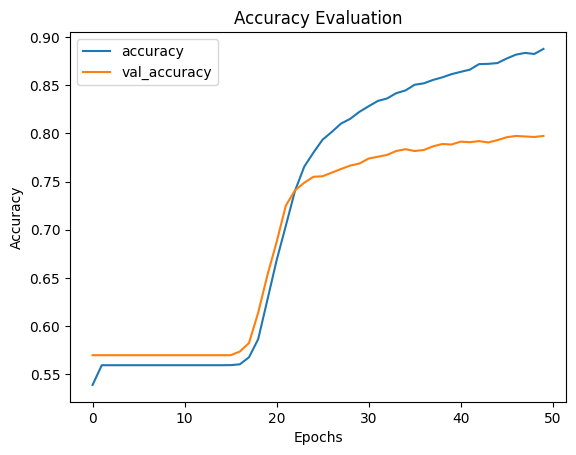

In [32]:
plot_model(history, "accuracy")

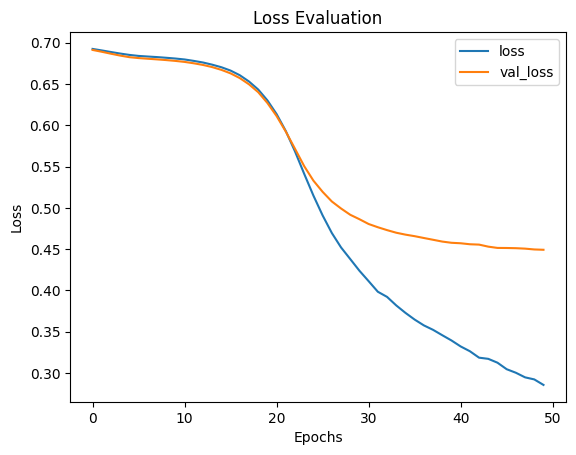

In [33]:
plot_model(history, "loss")

**Inference**
- It is clear that the model is diverging and overfitting to the data
- This is due to the usage of Dropout Regularisation on a very simple model architecture
- The use of lower learning rate has however smoothened the learning curves

## Utilising Pretrained Embeddings with RNN

- Similar to Transfer Learning in CNN's we can invoke pre-trained embeddings in the RNN's by downloading well trained embeddings.
- Using the GloVe Model (Global Vectors for World Representation)

**Extracting the GloVe Embeddings**

In [34]:
glove_embeddings = dict()

# Referring the to the Textfile containing the Embeddings
with open("/kaggle/input/glove-embeddings/glove.twitter.27B.25d.txt", "r") as embedding_file:
    
    # Splitting each embedding and its word into key value pairs for the dictionary
    lines = embedding_file.readlines()
    for line in lines:
        word_value_instance = line.split()
        word = word_value_instance[0]
        values = np.asarray(word_value_instance[1:], dtype="float32")
        glove_embeddings[word] = values
        
print("Viewing the Embeddings from the Dictionary:\n")
for i in list(glove_embeddings.items())[:5]:
    print(i)
    
print("\nTotal Length of the Dictionary: ", len(glove_embeddings))

Viewing the Embeddings from the Dictionary:

('<user>', array([ 0.62415 ,  0.62476 , -0.082335,  0.20101 , -0.13741 , -0.11431 ,
        0.77909 ,  2.6356  , -0.46351 ,  0.57465 , -0.024888, -0.015466,
       -2.9696  , -0.49876 ,  0.095034, -0.94879 , -0.017336, -0.86349 ,
       -1.3348  ,  0.046811,  0.36999 , -0.57663 , -0.48469 ,  0.40078 ,
        0.75345 ], dtype=float32))
('.', array([ 0.69586 , -1.1469  , -0.41797 , -0.022311, -0.023801,  0.82358 ,
        1.2228  ,  1.741   , -0.90979 ,  1.3725  ,  0.1153  , -0.63906 ,
       -3.2252  ,  0.61269 ,  0.33544 , -0.57058 , -0.50861 , -0.16575 ,
       -0.98153 , -0.8213  ,  0.24333 , -0.14482 , -0.67877 ,  0.7061  ,
        0.40833 ], dtype=float32))
(':', array([ 1.1242  ,  0.054519, -0.037362,  0.10046 ,  0.11923 , -0.30009 ,
        1.0938  ,  2.537   , -0.072802,  1.0491  ,  1.0931  ,  0.066084,
       -2.7036  , -0.14391 , -0.22031 , -0.99347 , -0.65072 , -0.030948,
       -1.0817  , -0.64701 ,  0.32341 , -0.41612 , -0.5268 

**Creating a New Matrix for the Word Index which uses the Embeddings as values for each Word Index**

In [35]:
# An array of zeros 
embedding_matrix = np.zeros((int(vocab_size), embedding_dim + 15))

for word, index in word_index:
    
    # Stopping the Loop after meeting the vocab size for the most frequently occuring words
    if index > vocab_size - 1:
        break
        
    else:
        embedding_vec = glove_embeddings.get(word)
        if embedding_vec is not None:
            embedding_matrix[index] = embedding_vec

## Model to Utilise Pretrained Word Embeddings

In [36]:
pretrained_embedding_model = Sequential([
    
    # Using the Pretrained Embeddings as Weights and Freezing the Training
    Embedding(int(vocab_size), embedding_dim + 15, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(25, return_sequences=True)),
    Bidirectional(LSTM(25)),
    Dense(25, activation="relu"),
    Dense(1, activation="sigmoid")
])

pretrained_embedding_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 25)          500000    
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 50)          10200     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 50)                15200     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 526701 (2.01 MB)
Trainable params: 26701

In [37]:
pretrained_embedding_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=Adam(learning_rate=1e-5)
)

In [38]:
history = pretrained_embedding_model.fit(
    train_set, train_labels, validation_data=(test_set, test_labels), epochs=40, verbose=2
)

Epoch 1/40
719/719 - 18s - loss: 0.6863 - accuracy: 0.5583 - val_loss: 0.6809 - val_accuracy: 0.5702 - 18s/epoch - 25ms/step
Epoch 2/40
719/719 - 10s - loss: 0.6796 - accuracy: 0.5609 - val_loss: 0.6740 - val_accuracy: 0.5719 - 10s/epoch - 14ms/step
Epoch 3/40
719/719 - 10s - loss: 0.6708 - accuracy: 0.5771 - val_loss: 0.6632 - val_accuracy: 0.6061 - 10s/epoch - 14ms/step
Epoch 4/40
719/719 - 10s - loss: 0.6555 - accuracy: 0.6283 - val_loss: 0.6468 - val_accuracy: 0.6514 - 10s/epoch - 13ms/step
Epoch 5/40
719/719 - 10s - loss: 0.6366 - accuracy: 0.6576 - val_loss: 0.6301 - val_accuracy: 0.6662 - 10s/epoch - 13ms/step
Epoch 6/40
719/719 - 10s - loss: 0.6199 - accuracy: 0.6705 - val_loss: 0.6171 - val_accuracy: 0.6767 - 10s/epoch - 14ms/step
Epoch 7/40
719/719 - 10s - loss: 0.6080 - accuracy: 0.6792 - val_loss: 0.6086 - val_accuracy: 0.6837 - 10s/epoch - 14ms/step
Epoch 8/40
719/719 - 10s - loss: 0.6003 - accuracy: 0.6835 - val_loss: 0.6018 - val_accuracy: 0.6846 - 10s/epoch - 13ms/step


**Model Performance**

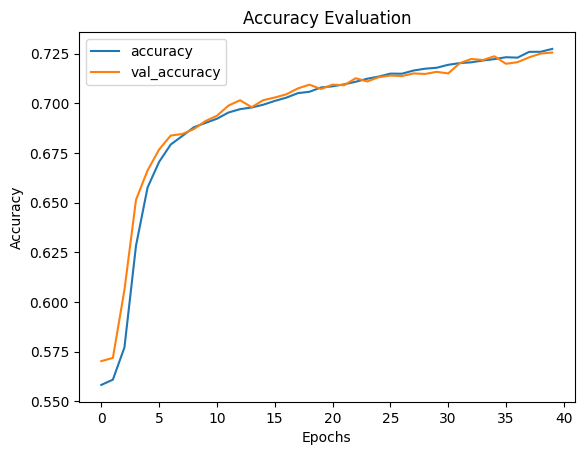

In [39]:
plot_model(history, "accuracy")

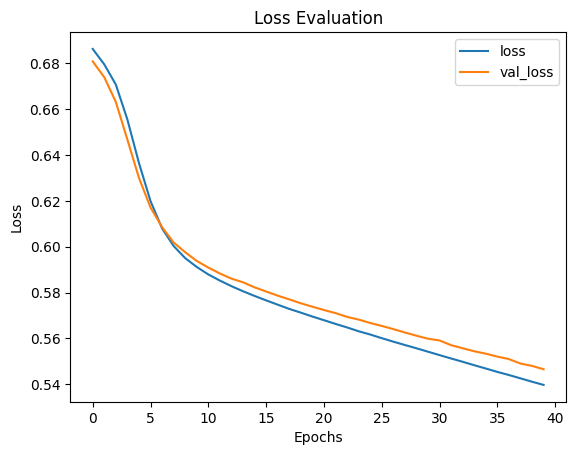

In [40]:
plot_model(history, "loss")

**Inference**
- We can see that the model is yet to converge and can reduce loss over training for longer epochs
- The GloVe Embeddings have provided more insight into understanding high frequency words thus providing a model which fits inline to the Training and Validation sets

**Optimising the Vocab Size**
- Calculating the Vocab Size wrt the words learnt by the Embeddings

In [41]:
xs = []
ys = []
cumulative_x = []
cumulative_y = []
total_y = 0

for word, index in word_index:
    
    # Appending all the index of all the words
    xs.append(index)
    cumulative_x.append(index)
    
    # Flagging the Words to check if they were present in the Embeddings
    if glove_embeddings.get(word) is not None:
        
        # Keeps track of the No of Words in Word_Index that were present in the Embedding
        total_y += 1
        ys.append(1)
        
    else:
        ys.append(0)
        
    # Taking a density estimation by comparing the percentage of words that were present in the Embeddings
    cumulative_y.append(total_y / index)

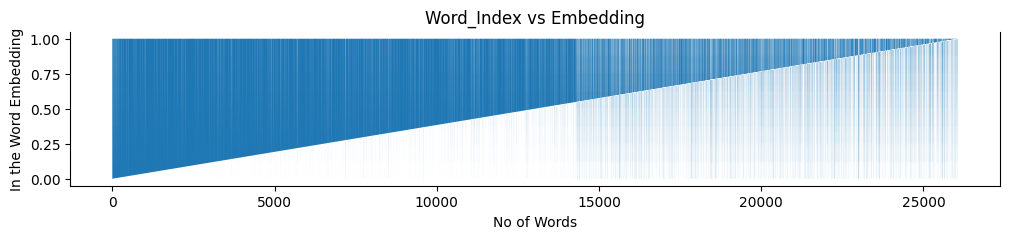

In [42]:
fig, ax = plt.subplots(figsize=(12, 2))
ax.spines["top"].set_visible(False)

plt.margins()
plt.title("Word_Index vs Embedding")
plt.xlabel("No of Words")
plt.ylabel("In the Word Embedding")
plt.fill(ys)

Text(0, 0.5, 'Percentage of Words in Embedding')

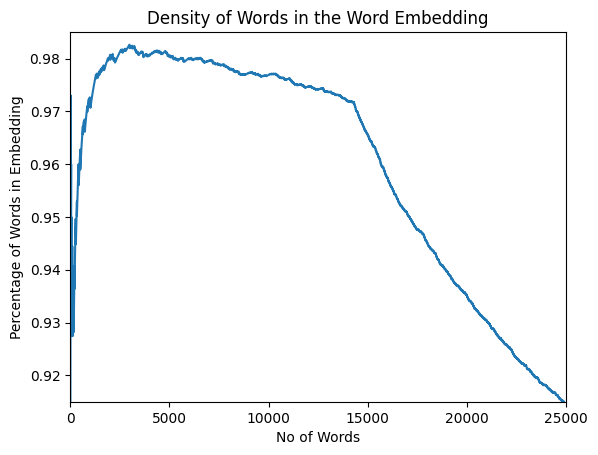

In [43]:
plt.plot(cumulative_x, cumulative_y)
plt.axis([0, 25000, 0.915, 0.985])

plt.title("Density of Words in the Word Embedding")
plt.xlabel("No of Words")
plt.ylabel("Percentage of Words in Embedding")

**Inference**
- By looking at the Density Graph we can see that at about 13800 - 14500 there is an inflexion point in the no of words present in the Embedding while training.
- Thus reducing the Vocab Size to this value can increase / retain performance while optimizing training.

In [44]:
vocab_size = 13800
new_embedding_matrix = np.zeros((vocab_size, 25))

for word, index in word_index:
    if index > vocab_size - 1:
        break
        
    else:
        embedding_vec = glove_embeddings.get(word)
        if embedding_vec is not None:
            new_embedding_matrix[index] = embedding_vec

## Optimised Model to Utilise Pretrained Embeddings

In [45]:
optimized_model = Sequential([
    Embedding(13800, 25, weights=[new_embedding_matrix], trainable=False),
    Bidirectional(LSTM(25, return_sequences=True)),
    Bidirectional(LSTM(25)),
    Dense(25, activation="relu"),
    Dense(1, activation="sigmoid")
])

optimized_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 25)          345000    
                                                                 
 bidirectional_4 (Bidirecti  (None, None, 50)          10200     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 50)                15200     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 371701 (1.42 MB)
Trainable params: 26701

In [46]:
optimized_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=Adam(learning_rate=1e-5)
)

In [47]:
history = optimized_model.fit(
    train_set, train_labels, validation_data=(test_set, test_labels), epochs=40, verbose=2
)

Epoch 1/40
719/719 - 17s - loss: 0.6872 - accuracy: 0.5672 - val_loss: 0.6827 - val_accuracy: 0.5721 - 17s/epoch - 24ms/step
Epoch 2/40
719/719 - 10s - loss: 0.6808 - accuracy: 0.5642 - val_loss: 0.6749 - val_accuracy: 0.5754 - 10s/epoch - 13ms/step
Epoch 3/40
719/719 - 10s - loss: 0.6711 - accuracy: 0.5820 - val_loss: 0.6630 - val_accuracy: 0.6201 - 10s/epoch - 13ms/step
Epoch 4/40
719/719 - 10s - loss: 0.6564 - accuracy: 0.6271 - val_loss: 0.6480 - val_accuracy: 0.6508 - 10s/epoch - 14ms/step
Epoch 5/40
719/719 - 10s - loss: 0.6414 - accuracy: 0.6487 - val_loss: 0.6351 - val_accuracy: 0.6560 - 10s/epoch - 14ms/step
Epoch 6/40
719/719 - 10s - loss: 0.6296 - accuracy: 0.6571 - val_loss: 0.6245 - val_accuracy: 0.6595 - 10s/epoch - 14ms/step
Epoch 7/40
719/719 - 10s - loss: 0.6209 - accuracy: 0.6663 - val_loss: 0.6168 - val_accuracy: 0.6668 - 10s/epoch - 13ms/step
Epoch 8/40
719/719 - 10s - loss: 0.6149 - accuracy: 0.6709 - val_loss: 0.6122 - val_accuracy: 0.6689 - 10s/epoch - 14ms/step


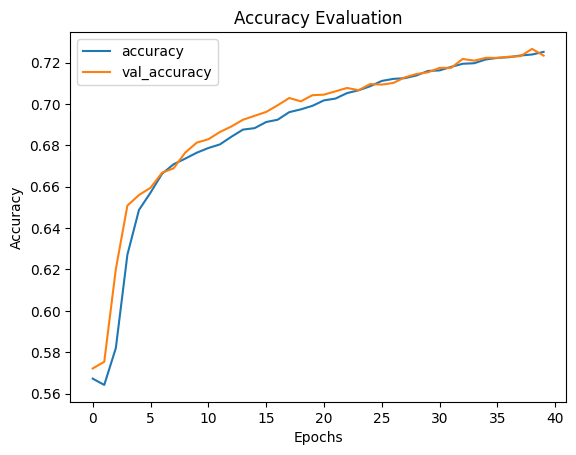

In [48]:
plot_model(history, "accuracy")

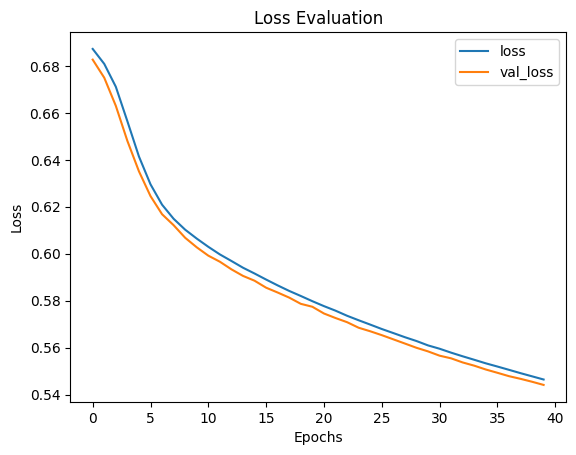

In [49]:
plot_model(history, "loss")

**Inference**
- We can see that the model is stable while taking longer to learn due to the reduced learning rate.
- There is still scope for improving the Transformation Phase to increase the performance of the Model.

## Making Predictions using the Optimized Model

In [50]:
test_sentences = [
    "I am not saying I hate you, what I'm saying is you are literally the Monday of my life",
    "It's ok if you dont like me, not everyone has a good taste",
    "I'm sorry while you were talking I was trying to figure out where the hell did you get the idea that I ever cared",
    "No you dont have to repeat yourself, I was ignoring you the first time around",
    "If this works, I will be super happy cause I have finally built an entire Natural Language Processing project by myself"
]

In [51]:
# Converting the Sentences to Sequences of Tokens
test_sequences = sarcasm_tokenizer.texts_to_sequences(test_sentences)

# Adding the Padding
padded_test_seq = pad_sequences(test_sequences, padding="post", truncating="post", maxlen=maxlen)

print("Viewing the Padding Sequences:\n")
for i in padded_test_seq:
    print(i, end="\n\n")

Viewing the Padding Sequences:

[   1    1    5 1150    1  503    1    1    1 1150    1    1    1 1902
    1 1554    1    1   28    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]

[   1 2836    1    1   96   22    1    5  200    1    1   63 2475    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]

[   1 1535    1    1    1  449    1    1  193    1 1553    1    1    1
  543    1    1   23    1  399    1    1  142    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 

In [52]:
predictions = optimized_model.predict(padded_test_seq)
print(predictions)

1/1 [==============================] - 1s 1s/step
[[0.62057453]
 [0.4306734 ]
 [0.7191184 ]
 [0.70943   ]
 [0.7908988 ]]


In [53]:
test_sentences

["I am not saying I hate you, what I'm saying is you are literally the Monday of my life",
 "It's ok if you dont like me, not everyone has a good taste",
 "I'm sorry while you were talking I was trying to figure out where the hell did you get the idea that I ever cared",
 'No you dont have to repeat yourself, I was ignoring you the first time around',
 'If this works, I will be super happy cause I have finally built an entire Natural Language Processing project by myself']

**Inference**
- The Model has predicted the sentences 1, 3 and 5 to be Sarcastic
- The Model seems to have missed sentences 2 and 4, given that these sentences are most likely not appearing on the headlines of a newspaper article.

# Wrap Up 😎
## I had a lot of fun creating this Kernal
## Hope you had fun reading it